<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%203/Case_Study_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import quopri
import codecs
import email
from gensim.parsing.preprocessing import STOPWORDS
from nltk import word_tokenize
import chardet
import os
import pandas as pd 
import numpy as np

In [5]:
file_list = []
for root, dirs, files in os.walk("/content/drive/MyDrive/SpamAssassinMessages/", topdown=False):
    for name in files:
        tmp = os.path.join(root,name)
        file_list.append(tmp)
    for item in dirs:
        print(item)
i=0

file_list_full = []
while i < len(file_list):
    file_list_full.append(file_list[i])
    i+=1

spam_2
spam
easy_ham_2
easy_ham
hard_ham


In [6]:
len(file_list_full)

9354

Option one-- sets the decoder dynamically, but still needs more work for pulling in information on other email types


In [7]:
i=0

contents = []
types = []
labels = []


for root, dirs, files in os.walk("/content/drive/MyDrive/SpamAssassinMessages/"):
    for name in files:
      
        #this may need to be adjusted-- 

        blob = open(file_list_full[i], 'rb').read()

        #determining the encoding of the email, so the open(os.path) portion doesn't hit an error downloading an email

        result = chardet.detect(blob)
        encoding_dynamic = result['encoding']

        #if 'unknown' in encoding_dynamic:
          #this needs to be setup to pull in the correct encoding when magic fails to identify the right encoding
         # encoding_dynamic='utf-8'

        with open(os.path.join(root,name), encoding=encoding_dynamic, errors='replace') as f:
            x = email.message_from_file(f)
            print('normal', file_list_full[i])
            i+=1
            
            if "multipart" in x.get_content_type():
                              # Clean up multipart email to raw string
                              content_parts = [part.get_payload().replace("\n", " ")
                                              for part in x.walk() if part.get_content_type() == "text/plain"]
                              content = "\n".join(content_parts)
                              contents.append(content)

                              types.append(x.get_content_type())

            elif "text/plain" in x.get_content_type():  #boy I hope all text messages are the same!
                # clean up multipart email to raw string
                contents.append(x.get_payload().replace("\n"," "))
                types.append(x.get_content_type())

            elif "html" in x.get_content_type():
                # clean up html email to raw string
                contents.append(x)
                types.append(x.get_content_type())

            if "ham" in root:
                labels.append(0)
            elif "spam" in root:
                labels.append(1)
            else:
                print("YOU HAVE A BIG PROBLEM--LABEL NOT FOUND")
                
        

Streaming output truncated to the last 5000 lines.
normal /content/drive/MyDrive/SpamAssassinMessages/easy_ham/0772.f6e3d3c433121335121efc42f2d81aa7
normal /content/drive/MyDrive/SpamAssassinMessages/easy_ham/0708.fe13d44640fb0f6e7d9d6a50c813a01f
normal /content/drive/MyDrive/SpamAssassinMessages/easy_ham/0706.ef90d85cf26d95101f9f5071ac457a81
normal /content/drive/MyDrive/SpamAssassinMessages/easy_ham/0753.45965735008c580a773f99eada080a27
normal /content/drive/MyDrive/SpamAssassinMessages/easy_ham/0736.0c8647e849c1d900b6af3a6c7024752d
normal /content/drive/MyDrive/SpamAssassinMessages/easy_ham/0774.cdd7992b853cadd1098b09224e74c728
normal /content/drive/MyDrive/SpamAssassinMessages/easy_ham/0843.6e5323ee268f72a690f5e5af60643e73
normal /content/drive/MyDrive/SpamAssassinMessages/easy_ham/0836.249730de164ba4999f1ab6ec2d3cb2d1
normal /content/drive/MyDrive/SpamAssassinMessages/easy_ham/0877.62f5636ba5885d1b92423169c83a35b9
normal /content/drive/MyDrive/SpamAssassinMessages/easy_ham/0863.3d

In [8]:
print('contents length: ', len(contents))
print('types length: ', len(types))
print('labels length: ', len(labels))
print('file list length: ', len(file_list_full))

contents length:  9354
types length:  9354
labels length:  9354
file list length:  9354


In [9]:
data = pd.DataFrame({"Text":contents,"Label":labels, "Type":types, "Filename": file_list_full})
data

,Text,Label,Type,Filename
0,SUBJECT: Urgent Concern Pl...,1,text/plain,/content/drive/MyDrive/SpamAssassinMessages/sp...
1,"[Return-Path, Delivery-Date, Received, Receive...",1,text/html,/content/drive/MyDrive/SpamAssassinMessages/sp...
2,"As seen on NBC, CBS, CNN, and even Oprah! The ...",1,text/plain,/content/drive/MyDrive/SpamAssassinMessages/sp...
3,,1,multipart/mixed,/content/drive/MyDrive/SpamAssassinMessages/sp...
4,"[Return-Path, Delivery-Date, Received, Receive...",1,text/html,/content/drive/MyDrive/SpamAssassinMessages/sp...
...,...,...,...,...
9349,"Hi XFS developers, When studying xfs code(2.4....",0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...
9350,My gut reaction would be to tell them to go an...,0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...
9351,* WORD A DAY * ---------...,0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...
9352,==============================================...,0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...


In [10]:
data[data['Type'].str.contains("html")]

,Text,Label,Type,Filename
1,"[Return-Path, Delivery-Date, Received, Receive...",1,text/html,/content/drive/MyDrive/SpamAssassinMessages/sp...
4,"[Return-Path, Delivery-Date, Received, Receive...",1,text/html,/content/drive/MyDrive/SpamAssassinMessages/sp...
6,"[Return-Path, Delivery-Date, Received, Receive...",1,text/html,/content/drive/MyDrive/SpamAssassinMessages/sp...
7,"[Return-Path, Delivery-Date, Received, Receive...",1,text/html,/content/drive/MyDrive/SpamAssassinMessages/sp...
8,"[Return-Path, Delivery-Date, Received, Receive...",1,text/html,/content/drive/MyDrive/SpamAssassinMessages/sp...
...,...,...,...,...
9332,"[Return-Path, Received, Received, Received, Me...",0,text/html,/content/drive/MyDrive/SpamAssassinMessages/ha...
9334,"[Return-Path, Delivery-Date, Return-Path, Rece...",0,text/html,/content/drive/MyDrive/SpamAssassinMessages/ha...
9338,"[Return-Path, Delivered-To, Received, Received...",0,text/html,/content/drive/MyDrive/SpamAssassinMessages/ha...
9343,"[Return-Path, Delivered-To, Received, Received...",0,text/html,/content/drive/MyDrive/SpamAssassinMessages/ha...


In [11]:
data

,Text,Label,Type,Filename
0,SUBJECT: Urgent Concern Pl...,1,text/plain,/content/drive/MyDrive/SpamAssassinMessages/sp...
1,"[Return-Path, Delivery-Date, Received, Receive...",1,text/html,/content/drive/MyDrive/SpamAssassinMessages/sp...
2,"As seen on NBC, CBS, CNN, and even Oprah! The ...",1,text/plain,/content/drive/MyDrive/SpamAssassinMessages/sp...
3,,1,multipart/mixed,/content/drive/MyDrive/SpamAssassinMessages/sp...
4,"[Return-Path, Delivery-Date, Received, Receive...",1,text/html,/content/drive/MyDrive/SpamAssassinMessages/sp...
...,...,...,...,...
9349,"Hi XFS developers, When studying xfs code(2.4....",0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...
9350,My gut reaction would be to tell them to go an...,0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...
9351,* WORD A DAY * ---------...,0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...
9352,==============================================...,0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
vectorizer = CountVectorizer()

In [14]:
data = data.astype({'Text':'string'})

In [15]:
out = vectorizer.fit_transform(data['Text'])

In [16]:
vectorizer.vocabulary_

{'subject': 90632,
 'urgent': 96681,
 'concern': 37213,
 'pls': 78183,
 'am': 25816,
 'serious': 86643,
 'officer': 74203,
 'with': 100050,
 'one': 74517,
 'of': 74148,
 'our': 75217,
 'main': 67618,
 'branches': 31913,
 'citi': 35800,
 'bank': 29231,
 'consumer': 37619,
 'banking': 29237,
 'department': 41142,
 'although': 25769,
 'we': 99081,
 'didn': 41806,
 'have': 56195,
 'previous': 79307,
 'correspondence': 38004,
 'till': 93541,
 'date': 40082,
 'however': 57639,
 'based': 29388,
 'on': 74495,
 'the': 92973,
 'standard': 89773,
 'value': 97253,
 'place': 77990,
 'everything': 47314,
 'about': 23785,
 'you': 101894,
 'believed': 30024,
 'could': 38085,
 'discuss': 42201,
 'analyze': 26072,
 'and': 26116,
 'execute': 47522,
 'this': 93254,
 'transaction': 94400,
 'is': 61094,
 'thus': 93431,
 've': 97419,
 'wealthy': 99100,
 'client': 36133,
 'an': 26029,
 'american': 25892,
 'citizen': 35806,
 'who': 99672,
 'had': 55762,
 'been': 29914,
 'residing': 83264,
 'in': 59423,
 'west'

In [17]:
data.iloc[0,0]

"SUBJECT:                     Urgent Concern Pls.  I am a serious officer with one of our main branches of CITI BANK, consumer Banking Department. Although we didn't have previous correspondence till date. However, based on the standard value place on everything about you,  I believed we could discuss, analyze and execute this transaction.The transaction is thus: I've a wealthy client, an American Citizen who had been residing in West Africa for decades now, he operates a fix deposit account with us which I am his account officer, and also  receives standing orders  for his chains of dividends share. However, this client Mr. David Brown died as an  out come of Heart attack,and the funds in his current account has  been claimed by his family, who had gone back finally to USA. At the end of Fiscal year, March 2001, an  accumulated share of US$12.360M was transferred into his account from the Stock Exchange. This was alone the instructions we issued to the Stock House to dispose all his s

In [18]:
reverse={}
for word,value in vectorizer.vocabulary_.items():
    reverse[value]=word

In [19]:
reverse[64792]

'landonline'

In [20]:
for i in range(out[0].shape[1]):
    if out[0,i]>0:
        print(reverse[i], out[0,i])

12 1
2001 1
360m 1
about 2
account 6
accumulated 1
africa 1
all 2
alone 1
along 1
also 2
although 1
am 3
american 1
an 4
analyze 1
and 7
anxiously 1
arrived 1
as 4
associate 2
at 1
attack 1
back 1
bank 1
banking 1
based 1
be 2
been 2
believed 1
branches 1
brown 2
by 1
chains 1
citi 1
citizen 1
claimed 1
claims 1
client 2
come 1
concern 1
consent 1
consumer 1
correspondence 1
could 1
current 1
date 1
dave 1
david 2
decades 1
department 1
deposit 2
details 1
didn 1
died 1
discuss 1
dispose 1
dividends 1
documents 1
easy 1
end 1
everything 1
exchange 2
execute 1
family 2
fax 1
finally 1
fiscal 1
fix 2
for 6
framo 1
from 1
fund 3
funds 3
furnish 2
further 1
go 1
gone 1
group 1
guided 1
had 2
has 5
have 1
he 1
hear 1
heart 1
his 8
house 1
however 2
http 1
ie 3
ilug 2
immediately 1
in 4
information 1
inheritor 1
instructions 1
into 1
involvement 1
irish 1
is 1
issued 1
it 1
know 1
left 1
linux 4
list 1
listinfo 1
listmaster 1
mailman 1
main 1
maintainer 1
march 1
matured 1
me 3
messages 1
mr

In [21]:
out[0,0]

0

Needs updating to email dataframe

In [53]:
target = data[['Label']]
train = data.loc[:, data.columns != 'Label']

from sklearn.feature_extraction.text import CountVectorizer
word_counts = CountVectorizer()
train= word_counts.fit_transform(train['Text'])
train = pd.DataFrame(data=train)

target = pd.DataFrame(data=target)

In [58]:
target

,Label
0,1
1,1
2,1
3,1
4,1
...,...
9349,0
9350,0
9351,0
9352,0


In [59]:
train

,0
0,"(0, 90632)\t1\n (0, 96681)\t2\n (0, 37213)..."
1,"(0, 90632)\t1\n (0, 100050)\t3\n (0, 74517..."
2,"(0, 90632)\t1\n (0, 74148)\t1\n (0, 75217)..."
3,
4,"(0, 90632)\t1\n (0, 100050)\t5\n (0, 74517..."
...,...
9349,"(0, 99081)\t1\n (0, 92973)\t5\n (0, 26116)..."
9350,"(0, 74517)\t2\n (0, 74148)\t1\n (0, 92973)..."
9351,"(0, 25816)\t1\n (0, 100050)\t5\n (0, 74517..."
9352,"(0, 90632)\t1\n (0, 100050)\t5\n (0, 74148..."


In [54]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(train,target,test_size=0.2)
#x_train = np.array(x_train)
#x_test = np.array(x_test)

#x_train=x_train.todense()
#y_train=y_train.todense()


#y_train = np.array(y_train.astype('int'))
#y_test = np.array(y_test.astype('int'))

In [57]:
from sklearn.naive_bayes import ComplementNB, BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB

gaus = CategoricalNB()

#gaus.fit(x_train, y_train, np.unique(y_train))

gaus.fit(x_train, y_train)

p = gaus.predict(y_test)
print(accuracy_score(y_test['Label'],p), f"method={i}")
print(classification_report(y_test['Label'],p))

ValueError: ignored

In [31]:
from sklearn.naive_bayes import ComplementNB, BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

comp = ComplementNB()
bern = BernoulliNB()
gaus = GaussianNB()
cat = CategoricalNB()
multi = MultinomialNB()
methods = {"Complement":comp,"Bernoulli":bern,"Gausian":gaus,"Multi":multi,"Cat":cat}
for i in methods.keys():
    try:
        methods[i].fit(x_train, y_train)
        p = methods[i].predict(y_test)
        print(accuracy_score(y_test['Label'],p), f"method={i}")
        print(classification_report(y_test['Label'],p))
    except:
        print(f"{i} failed")


Complement failed
Bernoulli failed
Gausian failed
Multi failed
Cat failed


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


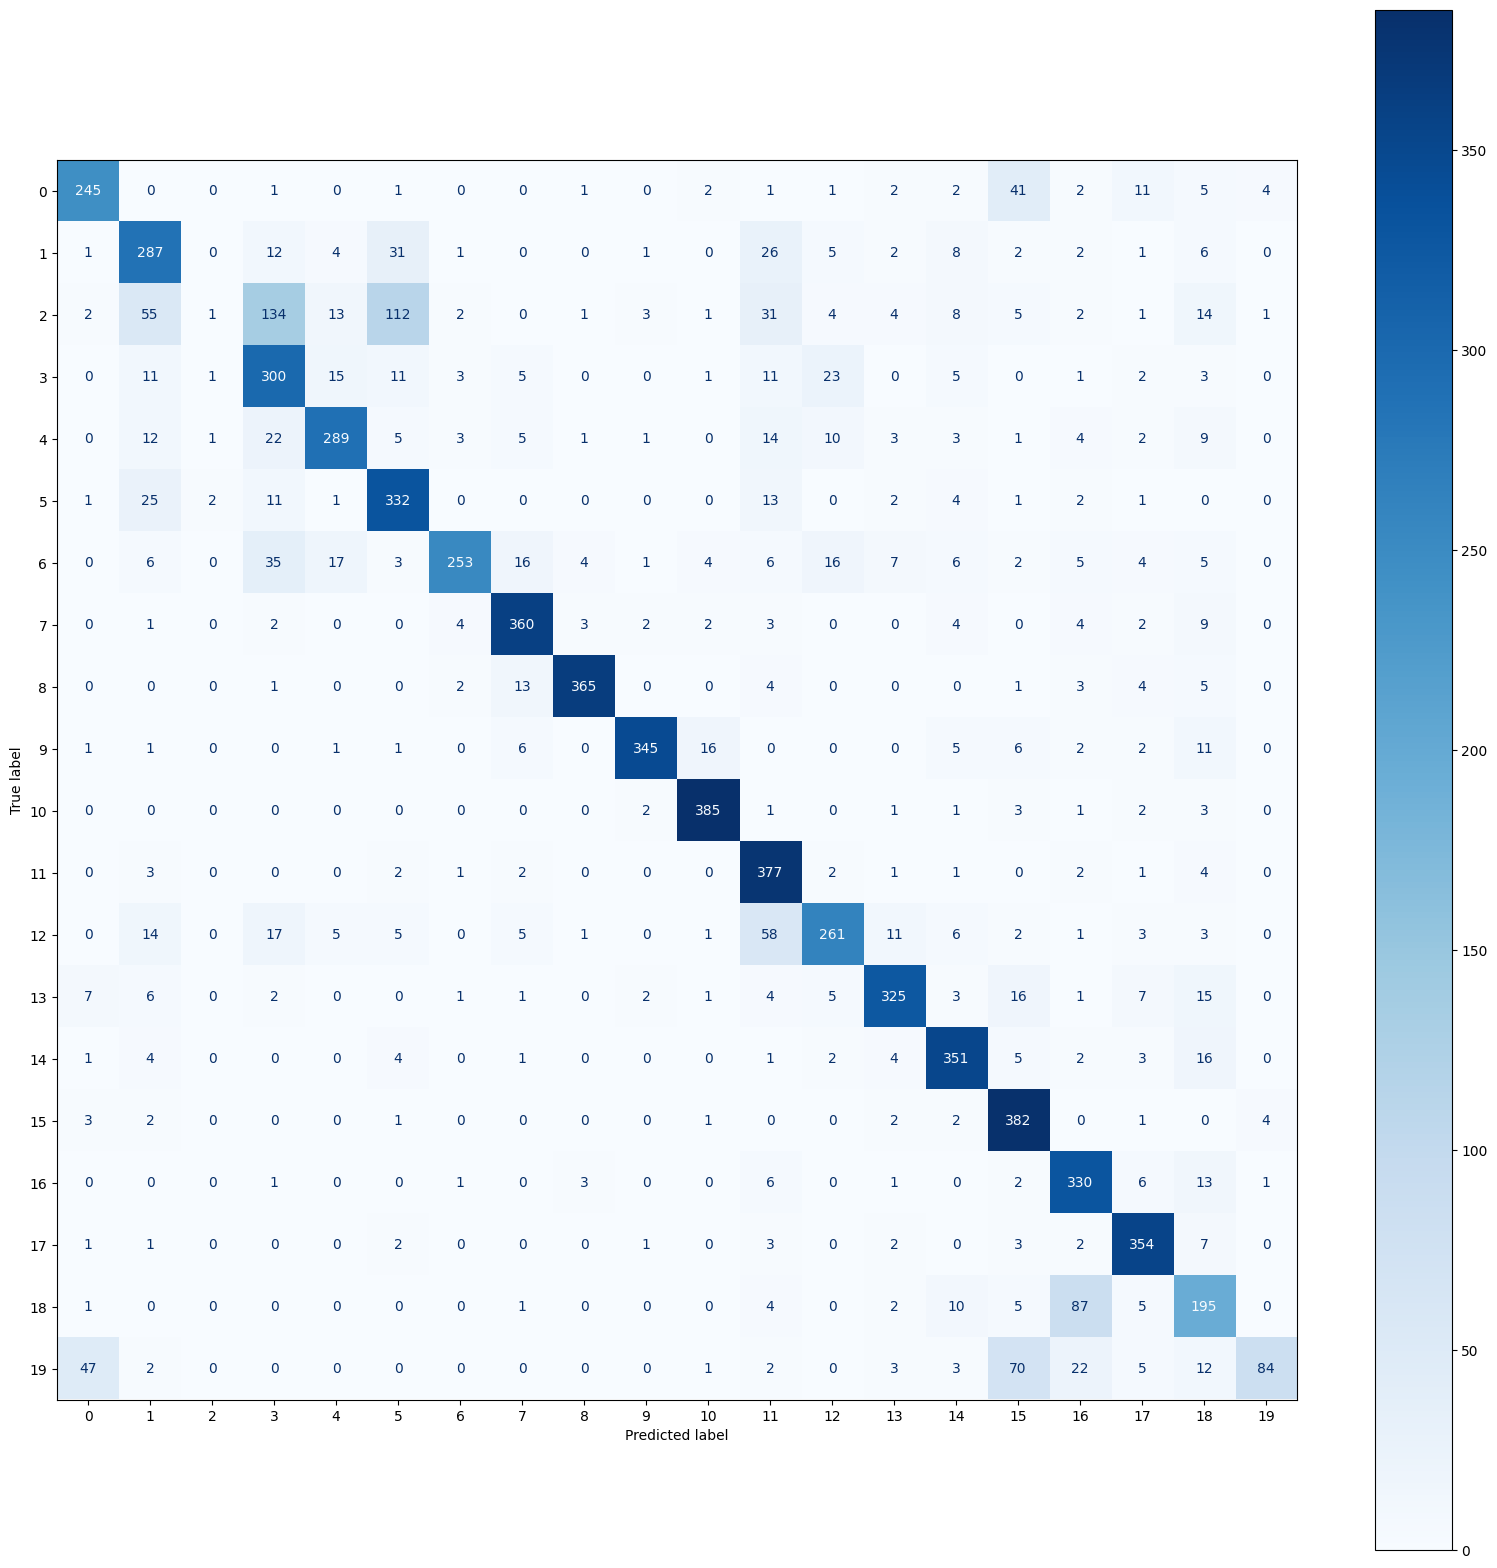

In [80]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
ConfusionMatrixDisplay.from_predictions(test['target'],p,cmap='Blues')

In [81]:
reverse={}
for word,value in word_counts.vocabulary_.items():
    reverse[value]=word